<a href="https://www.kaggle.com/code/minseo14/arc-task-00d62c1b-with-cnn?scriptVersionId=189980185" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# ARC Task 00d62c1b with CNN!
> ### Models in this page are specialized only for the single data, 00d62c1b. 
> ### Still a necessary step though!

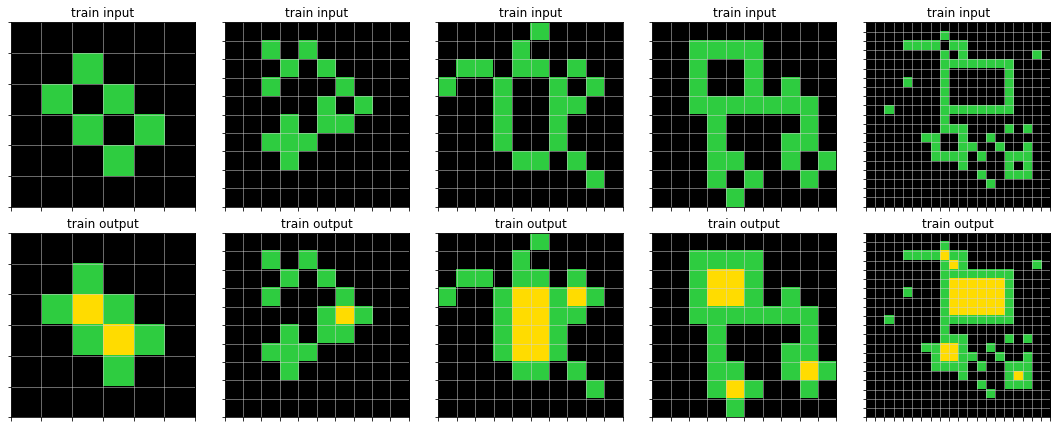

## Abastract
    CNNs seems have a limitation to detect all borders without long term memory.
### Next Step 
    Apply boundary fill algorithm from the border of the image detecting nearby pixels having the same color. 
    Then detect the significant rest pixels

### Extention (To aproach end-to-end)
    Classify whether the shape is stable or not.
    Predict what kind of pattern/roles each task/color has.
    
### Citation of code
> [Basic Attention Model - deep-learning-from-scratch-2](https://github.com/oreilly-japan/deep-learning-from-scratch-2/tree/master/ch08)

---

# Step 0: Setup

## 0-1. Install Libraries and Import Modules

> ### Add Path

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arc-prize-2024/arc-agi_training_solutions.json
/kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json
/kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json
/kaggle/input/arc-prize-2024/sample_submission.json
/kaggle/input/arc-prize-2024/arc-agi_training_challenges.json
/kaggle/input/arc-prize-2024/arc-agi_test_challenges.json
/kaggle/input/arcsourcecode/data.py
/kaggle/input/arcsourcecode/train.py
/kaggle/input/arcsourcecode/test.py
/kaggle/input/arcsourcecode/classify.py
/kaggle/input/arcsourcecode/2_00d62c1b.png
/kaggle/input/arcsourcecode/configs/train.yaml
/kaggle/input/arcsourcecode/configs/test.yaml
/kaggle/input/arcsourcecode/configs/model/FillerKeepInputIgnoreColor.yaml
/kaggle/input/arcsourcecode/configs/model/FillerKeepInput.yaml
/kaggle/input/arcsourcecode/configs/data/FillerKeepInput_test.yaml
/kaggle/input/arcsourcecode/configs/data/FillerKeepInput_train.yaml
/kaggle/input/arcsourcecode/configs/data/FillerKeepInputIgnoreColor_test.yaml
/kagg

In [2]:
import sys
sys.path.insert(1, '/kaggle/input/arcsourcecode')

> ### Install Hydra

In [3]:
!pip install hydra-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.3 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=d6d88dc0a0004944a5a0d39a2b0fb9967325322d96ed3b117e3361e71e6eb039
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


> ### Load Config Files and Train/Test Functions

In [4]:
from omegaconf import OmegaConf
import torch
from torch import nn
import torch.nn.functional as F

from train import train
from test import test

In [5]:
base_path = '/kaggle/input/arc-prize-2024/'
config_path = '/kaggle/input/arcsourcecode/configs/'

def load_config(path, config_path=config_path):
    return OmegaConf.load(config_path + path)

# Hyperparameters for Training
def load_train_config(ignore_color=False):
    if ignore_color:
        config_data = load_config("data/FillerKeepInputIgnoreColor_train.yaml")
        config_model = load_config("model/FillerKeepInputIgnoreColor.yaml")
        config_train = load_config("train/FillerKeepInputIgnoreColor.yaml")
        config_test = load_config("test/FillerKeepInputIgnoreColor.yaml")
    else:
        config_data = load_config("data/FillerKeepInput_train.yaml")
        config_model = load_config("model/FillerKeepInput.yaml")
        config_train = load_config("train/FillerKeepInput.yaml")
        config_test = load_config("test/FillerKeepInput.yaml")
        
    config_train = OmegaConf.merge({'data': config_data, 'model': config_model, 'train': config_train, 'test': config_test})
    config_train.data.params.base_path = '/kaggle/input/arc-prize-2024/'
    config_train.save_path = './output/'
    
    return config_train

# Hyperparameters for Testing
def load_test_config(ignore_color=False):
    if ignore_color:
        config_data = load_config("data/FillerKeepInputIgnoreColor_test.yaml")
        config_model = load_config("model/FillerKeepInputIgnoreColor.yaml")
        config_test = load_config("test/FillerKeepInputIgnoreColor.yaml")
    else:
        config_data = load_config("data/FillerKeepInput_test.yaml")
        config_model = load_config("model/FillerKeepInput.yaml")
        config_test = load_config("test/FillerKeepInput.yaml")
    
    config_test = OmegaConf.merge({'data': config_data, 'model': config_model, 'test': config_test})
    config_test.data.params.base_path = '/kaggle/input/arc-prize-2024/'
    
    return config_test

## 0-2. Data Augmentation (Rotation, Flipping)

Data size: 5

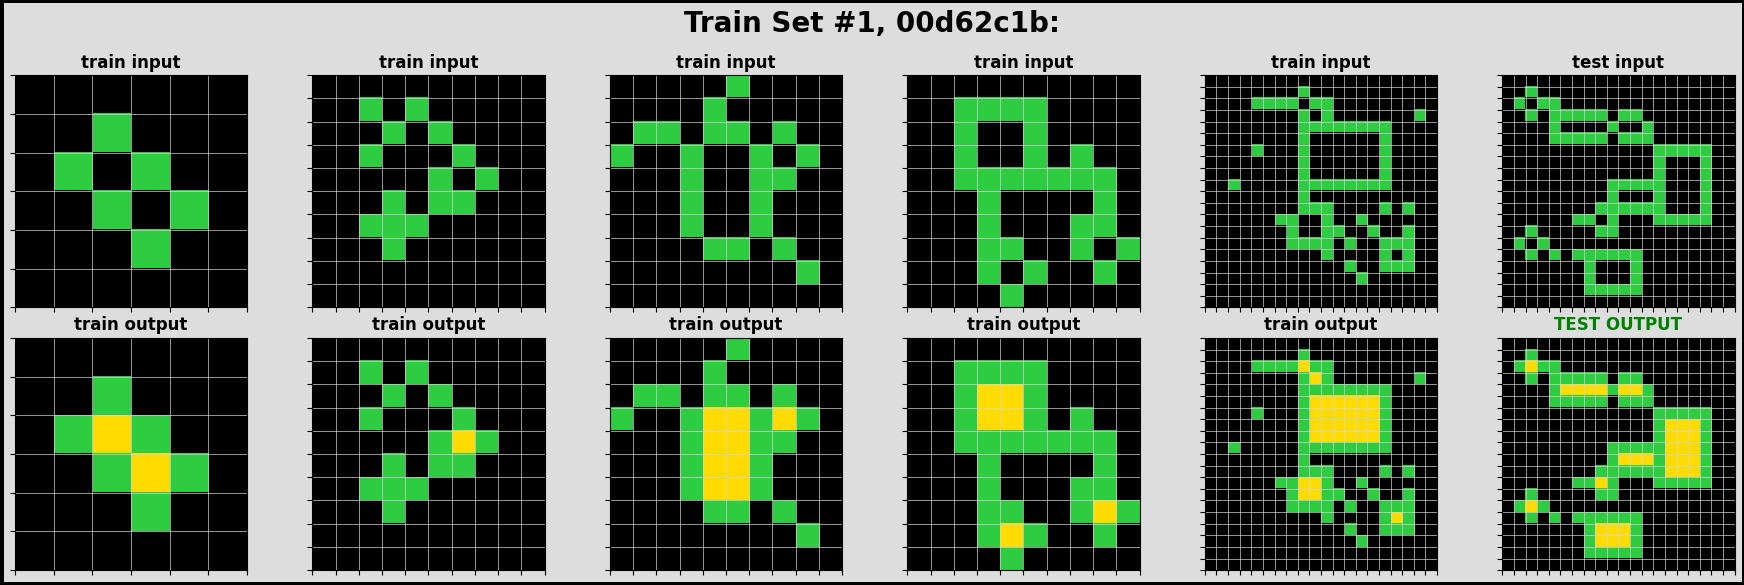

In [6]:
from rich import print
from data import ARCDataset
from arc_prize.constants import get_challenges_solutions_filepath
from arc_prize.utils.visualize import plot_task
from classify import ARCDataClassifier


data_category = 'train'
challenges, solutions = get_challenges_solutions_filepath(data_category, base_path)

# Filtering Dataset
filter_funcs = (
    ARCDataClassifier.in_data_codes_f(['00d62c1b']),
#     ARCDataClassifier.is_same_shape_f(True),
#     ARCDataClassifier.is_n_m_colored_in_out_f(2, 3),
#     ARCDataClassifier.is_dominent_color_stable_f(True),
)

dataset = ARCDataset(challenges, solutions, one_hot=False, filter_funcs=filter_funcs)
print(f'Data size: {len(dataset[0][0])}')

# Visualize a task
for index in range(len(dataset)):
    plot_task(dataset, index, data_category)
    break

Data size: 34

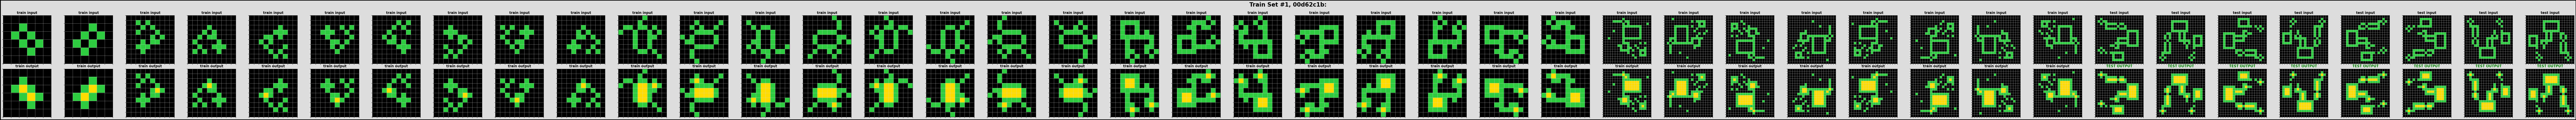

In [7]:
dataset = ARCDataset(challenges, solutions, one_hot=False, filter_funcs=filter_funcs, augment_data=True)
print(f'Data size: {len(dataset[0][0])}')

# Visualize a task
for index in range(len(dataset)):
    plot_task(dataset, index, data_category='Train')
    break

# Step 1: Consider which pixel to be substituted

## 1-1. Predict the positions to be substituted

In [8]:
config = load_train_config(ignore_color=True)
train(config)

data:
  name: FillerKeepInputIgnoreColor
  params:
    base_path: /kaggle/input/arc-prize-2024/
    cold_value: -1
    augment_data: true
    ignore_color: true
model:
  name: FillerKeepInputIgnoreColor
  params:
    reduced_channels_encoder:
    - 512
    - 32
    reduced_channels_decoder:
    - 32
    - 32
train:
  name: default
  params:
    max_epochs: 60
    batch_size_max: 8
    lr: 0.01
    save_dir: ./output/
    ckpt_path: null
test:
  name: default
  params:
    model_path: ./output/FillerKeepInputIgnoreColor.ckpt
    verbose_single: false
save_path: ./output/

FillerKeepInputIgnoreColorL(
  (model): FillerKeepInputIgnoreColor(
    (feature_extractor): ConvFeatureExtractor(
      (encoder): Conv2dEncoderLayer(
        (conv): Conv2dFixedKernel(1, 512, kernel_size=(3, 3), stride=(1, 1))
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=512, out_features=32, bias=False)
          (relu_0): ReLU()
        )
        (norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (extender): Conv2dEncoderLayer(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=32, out_features=32, bias=False)
          (relu_0): ReLU()
        )
        (norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (decoder): Conv2dEncoderLayer(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=32, out_features=32, bias=False)
          (relu_0): ReLU()
          (out): Linear(in_features=32, out_features=1, bias=False)
        )
        (norm): InstanceNorm2d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (attn_reduction): ReductiveAttention(
        (attention_weight_layer): AttentionWeight()
        (weight_sum_layer): WeightSum()
      )
    )
  )
  (loss_fn_source): BCEWithLogitsLoss()
)

2024-07-27 09:26:34.657712: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-27 09:26:34.657870: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-27 09:26:34.791824: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type                       ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model          │ FillerKeepInputIgnoreColor │ 42.0 K │ train │
│ 1 │ loss_fn_source │ BCEWithLogitsLoss          │      0 │ train │
└───┴────────────────┴────────────────────────────┴────────┴───────┘

Trainable params: 36.9 K                                                                                           
Non-trainable params: 5.1 K                                                                                        
Total params: 42.0 K                                                                                               
Total estimated model params size (MB): 0

Output()

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is 
incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()

Epoch 1 | Train loss: 3.679354 | N Pixels Wrong: 1719

Epoch 2 | Train loss: 3.390815 | N Pixels Wrong: 1186

Epoch 3 | Train loss: 3.201451 | N Pixels Wrong: 958

Epoch 4 | Train loss: 3.044523 | N Pixels Wrong: 739

Epoch 5 | Train loss: 2.972055 | N Pixels Wrong: 518

Epoch 6 | Train loss: 2.901841 | N Pixels Wrong: 346

Epoch 7 | Train loss: 2.870960 | N Pixels Wrong: 319

Epoch 8 | Train loss: 2.840362 | N Pixels Wrong: 239

Epoch 9 | Train loss: 2.807956 | N Pixels Wrong: 135

Epoch 10 | Train loss: 2.789578 | N Pixels Wrong: 104

Epoch 11 | Train loss: 2.779000 | N Pixels Wrong: 99

Epoch 12 | Train loss: 2.768428 | N Pixels Wrong: 90

Epoch 13 | Train loss: 2.763202 | N Pixels Wrong: 75

Epoch 14 | Train loss: 2.757637 | N Pixels Wrong: 58

Epoch 15 | Train loss: 2.754626 | N Pixels Wrong: 63

Epoch 16 | Train loss: 2.753097 | N Pixels Wrong: 39

Epoch 17 | Train loss: 2.752875 | N Pixels Wrong: 36

Epoch 18 | Train loss: 2.751702 | N Pixels Wrong: 32

Epoch 19 | Train loss: 2.750456 | N Pixels Wrong: 25

Epoch 20 | Train loss: 2.749737 | N Pixels Wrong: 23

Epoch 21 | Train loss: 2.749459 | N Pixels Wrong: 23

Epoch 22 | Train loss: 2.749161 | N Pixels Wrong: 18

Epoch 23 | Train loss: 2.748841 | N Pixels Wrong: 9

Epoch 24 | Train loss: 2.748606 | N Pixels Wrong: 7

Epoch 25 | Train loss: 2.748456 | N Pixels Wrong: 5

Epoch 26 | Train loss: 2.748312 | N Pixels Wrong: 5

Epoch 27 | Train loss: 2.748263 | N Pixels Wrong: 6

Epoch 28 | Train loss: 2.748166 | N Pixels Wrong: 5

Epoch 29 | Train loss: 2.748149 | N Pixels Wrong: 3

Epoch 30 | Train loss: 2.748014 | N Pixels Wrong: 3

Epoch 31 | Train loss: 2.747955 | N Pixels Wrong: 2

Epoch 32 | Train loss: 2.747931 | N Pixels Wrong: 2

Epoch 33 | Train loss: 2.747872 | N Pixels Wrong: 2

Epoch 34 | Train loss: 2.747812 | N Pixels Wrong: 1

Epoch 35 | Train loss: 2.747791 | N Pixels Wrong: 1

Epoch 36 | Train loss: 2.747822 | N Pixels Wrong: 1

Epoch 37 | Train loss: 2.747789 | N Pixels Wrong: 0

Epoch 38 | Train loss: 2.747726 | N Pixels Wrong: 0

Epoch 39 | Train loss: 2.747708 | N Pixels Wrong: 0

Epoch 40 | Train loss: 2.747735 | N Pixels Wrong: 0

Model saved to: ./output/FillerKeepInputIgnoreColor_40ep.ckpt

Epoch 41 | Train loss: 2.747823 | N Pixels Wrong: 0

Epoch 42 | Train loss: 2.747731 | N Pixels Wrong: 0

Epoch 43 | Train loss: 2.747685 | N Pixels Wrong: 0

Epoch 44 | Train loss: 2.747675 | N Pixels Wrong: 0

Epoch 45 | Train loss: 2.747628 | N Pixels Wrong: 0

Epoch 46 | Train loss: 2.747605 | N Pixels Wrong: 0

Epoch 47 | Train loss: 2.747591 | N Pixels Wrong: 0

Epoch 48 | Train loss: 2.747576 | N Pixels Wrong: 0

Epoch 49 | Train loss: 2.747573 | N Pixels Wrong: 0

Epoch 50 | Train loss: 2.747568 | N Pixels Wrong: 0

Epoch 51 | Train loss: 2.747559 | N Pixels Wrong: 0

Epoch 52 | Train loss: 2.747549 | N Pixels Wrong: 0

Epoch 53 | Train loss: 2.747540 | N Pixels Wrong: 0

Epoch 54 | Train loss: 2.747534 | N Pixels Wrong: 0

Epoch 55 | Train loss: 2.747526 | N Pixels Wrong: 0

Epoch 56 | Train loss: 2.747520 | N Pixels Wrong: 0

Epoch 57 | Train loss: 2.747518 | N Pixels Wrong: 0

Epoch 58 | Train loss: 2.747536 | N Pixels Wrong: 0

Epoch 59 | Train loss: 2.747545 | N Pixels Wrong: 0

Epoch 60 | Train loss: 2.747522 | N Pixels Wrong: 0

Seed used 1942216767871883170

Model saved to: ./output/FillerKeepInputIgnoreColor.ckpt

data:
  name: FillerKeepInputIgnoreColor
  params:
    base_path: /kaggle/input/arc-prize-2024/
    cold_value: -1
    augment_data: false
    ignore_color: true
model:
  name: FillerKeepInputIgnoreColor
  params:
    reduced_channels_encoder:
    - 512
    - 32
    reduced_channels_decoder:
    - 32
    - 32
test:
  name: default
  params:
    model_path: ./output/FillerKeepInputIgnoreColor.ckpt
    verbose_single: false

Task: 00d62c1b | train 1 |  77.78% correct | 8 Pixels Wrong

Task: 00d62c1b | train 2 |  84.00% correct | 16 Pixels Wrong

Task: 00d62c1b | train 3 |  69.00% correct | 31 Pixels Wrong

Task: 00d62c1b | train 4 |  65.00% correct | 35 Pixels Wrong

Task: 00d62c1b | train 5 |  75.50% correct | 98 Pixels Wrong

Task: 00d62c1b |  test 1 |  70.00% correct | 120 Pixels Wrong

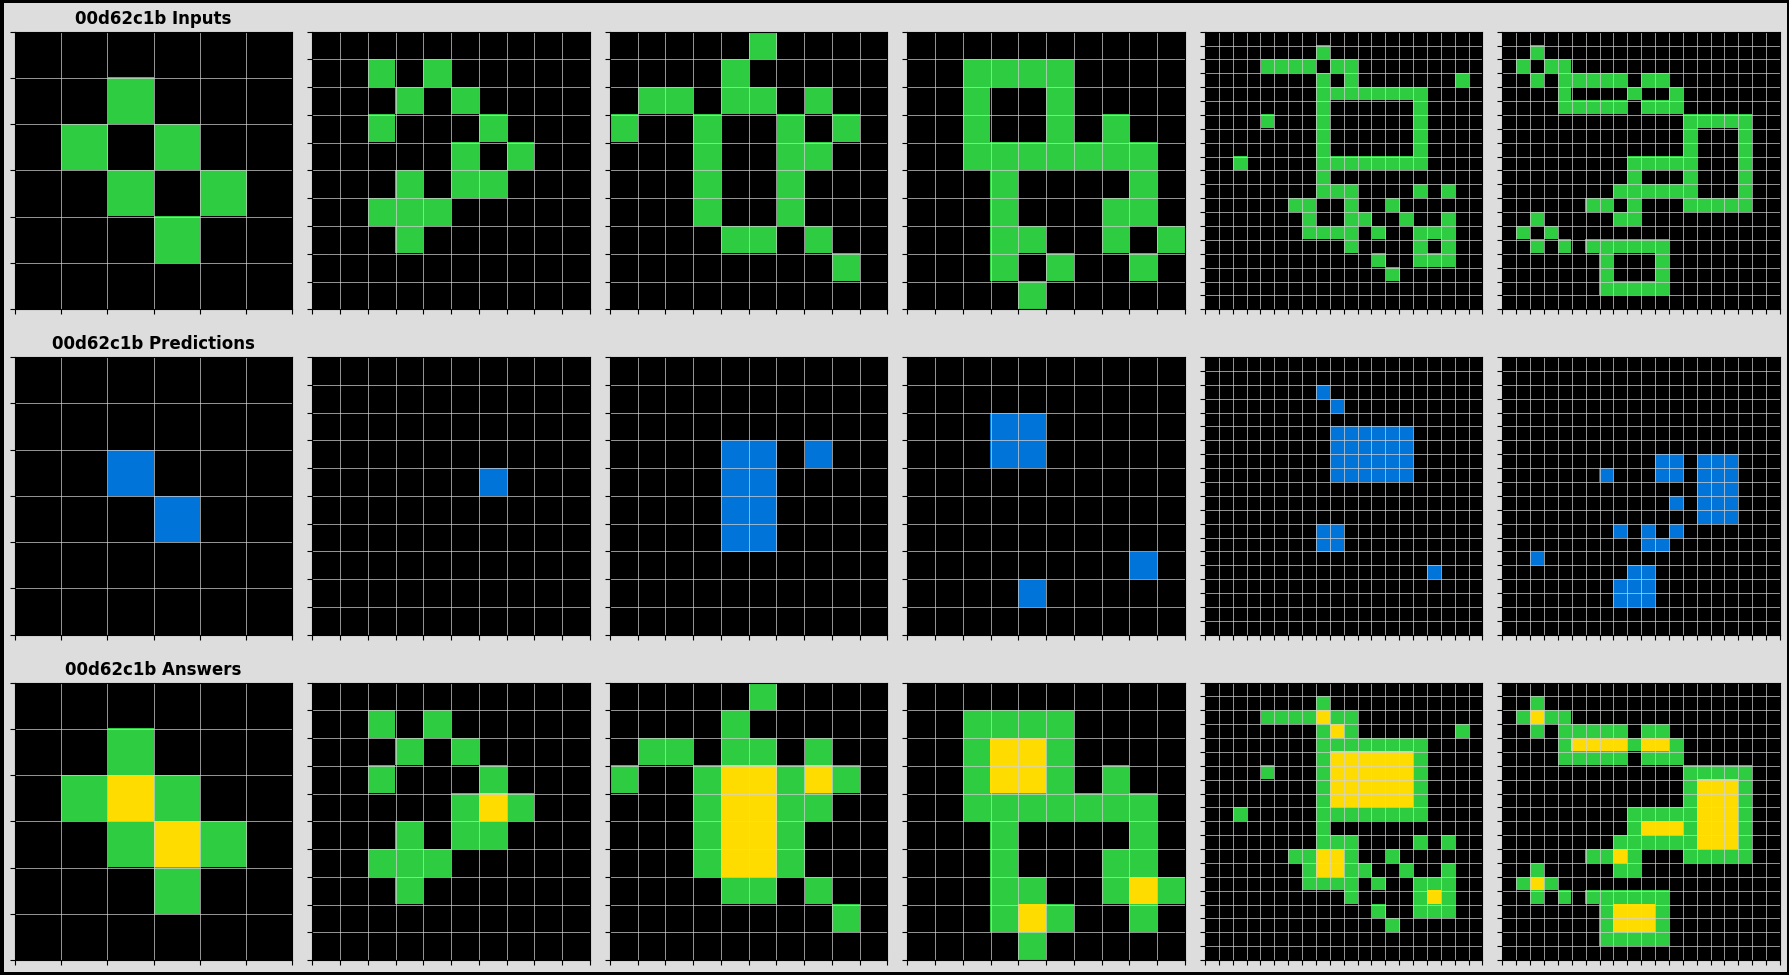

In [9]:
config = load_test_config(ignore_color=True)
test(config)

# Step 2: Consider pixel colors as well

## 2-1. Predict pixels to be kept

In [10]:
class FillerKeepInput(nn.Module):
    def __init__(self, reduced_channels_encoder=[512, 32], reduced_channels_decoder=[128, 32], pad_value=-1, num_classes=10, feature_dim=1, color_dim=1, **kwargs):
        super().__init__()
        self.color_vector = nn.Parameter(torch.randn(num_classes, feature_dim)) # dim-1 because the first channel is the input

        self.attn_input = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=num_classes, nhead=1, dim_feedforward=1, batch_first=True, bias=False),
            num_layers=1,
        )

        self.decoder = nn.Sequential(
            nn.Linear(color_dim, 1, bias=False),
        )

    def forward(self, x, **kwargs):
        N, C, H, W = x.shape

        y = self.color_vector.repeat(N*H*W, 1, 1) # [N*H*W, C, V]
        V = y.shape[2]
        y = y.transpose(2, 1) # [N*H*W, V, C]

        x = x.permute(0, 2, 3, 1).reshape(N*H*W, 1, C) # [N*H*W, V, C]
        y = self.attn_input(y, x)
        y = y.transpose(2, 1) # [N*H*W, C, V]

        y = y.reshape(N*H*W*C, V)
        y = self.decoder(y) # [N*H*W*C, 1]
        y = y.view(N, H, W, C).permute(0, 3, 1, 2) # [N, C, H, W]

        return y

In [11]:
config = load_train_config()
config.train.params.max_epochs = 10
model = train(config, FillerKeepInput, test=True) # Apply custom model

data:
  name: FillerKeepInput
  params:
    base_path: /kaggle/input/arc-prize-2024/
    cold_value: -1
    augment_data: true
    ignore_color: false
model:
  name: FillerKeepInput
  params:
    reduced_channels_encoder:
    - 512
    - 32
    reduced_channels_decoder:
    - 32
    - 32
    pad_value: -1
    d_conv_feature: 16
    d_color_feature: 32
train:
  name: default
  params:
    max_epochs: 10
    batch_size_max: 8
    lr: 0.01
    save_dir: ./output/
    ckpt_path: null
test:
  name: FillerKeepInput
  params:
    model_path: ./output/FillerKeepInput.ckpt
    verbose_single: false
    n_recurrance_feature_extraction: null
save_path: ./output/

FillerKeepInputL(
  (model): FillerKeepInput(
    (attn_input): TransformerDecoder(
      (layers): ModuleList(
        (0): TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=False)
          )
          (multihead_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=False)
          )
          (linear1): Linear(in_features=10, out_features=1, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1, out_features=10, bias=False)
          (norm1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm3): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
          (dropout3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): Sequential(
      (0): Linear(in_features=1, out_features=1, bias=False)
    )
  )
  (loss_fn_source): CrossEntropyLoss()
)

┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model          │ FillerKeepInput  │    861 │ train │
│ 1 │ loss_fn_source │ CrossEntropyLoss │      0 │ train │
└───┴────────────────┴──────────────────┴────────┴───────┘

Trainable params: 861                                                                                              
Non-trainable params: 0                                                                                            
Total params: 861                                                                                                  
Total estimated model params size (MB): 0

Output()

Epoch 1 | Train loss: 8.912464 | N Pixels Wrong: 4073

Epoch 2 | Train loss: 6.162163 | N Pixels Wrong: 1557

Epoch 3 | Train loss: 5.207056 | N Pixels Wrong: 1449

Epoch 4 | Train loss: 4.394197 | N Pixels Wrong: 1382

Epoch 5 | Train loss: 3.628104 | N Pixels Wrong: 728

Epoch 6 | Train loss: 2.970995 | N Pixels Wrong: 617

Epoch 7 | Train loss: 2.440017 | N Pixels Wrong: 532

Epoch 8 | Train loss: 2.198800 | N Pixels Wrong: 537

Epoch 9 | Train loss: 2.075427 | N Pixels Wrong: 526

Epoch 10 | Train loss: 1.900663 | N Pixels Wrong: 502

Seed used 3823408562624121176

Model saved to: ./output/FillerKeepInput.ckpt

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│   1 config = load_train_config()                                                                 │
│   2 config.train.params.max_epochs = 10                                                          │
│ ❱ 3 model = train(config, FillerKeepInput, test=True) # Apply custom model                       │
│   4                                                                                              │
│                                                                                                  │
│ /kaggle/input/arcsourcecode/train.py:79 in train                                                 │
│                                                                                                  │
│    76 │                                                                                          │
│    77 │   if test:                                                                               │
│    78 │   │   with open_dict(config):                                                            │
│ ❱  79 │   │   │   hparams_data.augment_data = False                                              │
│    80 │   │                                                                                      │
│    81 │   │   test_fn(config, model)                                                             │
│    82                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'dict' object has no attribute 'augment_data'

## 2-2. Predict which pixels to be kept and replaced by which color

### Fast Version with Simple Attention over Recurrence of Convolution Layer's Output

In [ ]:
# https://github.com/oreilly-japan/deep-learning-from-scratch-2/blob/master/ch08/attention_seq2seq.py

class AttentionWeight(nn.Module):
    def __init__(self):
        super(AttentionWeight, self).__init__()

    def forward(self, hs, h):
        # hs: batch_size x seq_len x hidden_dim
        # h: batch_size x hidden_dim
        # Expanding h to match hs's dimensions for batch-wise multiplication
        hr = h.unsqueeze(1)  # shape: batch_size x 1 x hidden_dim
        t = hs * hr
        s = torch.sum(t, dim=2)  # Sum across hidden_dim
        a = F.softmax(s, dim=1)  # Apply softmax across seq_len
        return a

class WeightSum(nn.Module):
    def __init__(self):
        super(WeightSum, self).__init__()

    def forward(self, hs, a):
        # hs: batch_size x seq_len x hidden_dim
        # a: batch_size x seq_len
        # Need to expand a for element-wise multiplication
        ar = a.unsqueeze(2)  # shape: batch_size x seq_len x 1
        t = hs * ar
        c = torch.sum(t, dim=1)  # Sum across seq_len
        return c

class ReductiveAttention(nn.Module):
    def __init__(self):
        super(ReductiveAttention, self).__init__()
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()

    def forward(self, hs, h):
        # hs: batch_size x seq_len x hidden_dim
        # h: batch_size x hidden_dim
        a = self.attention_weight_layer(hs, h)
        out = self.weight_sum_layer(hs, a)
        return out

In [ ]:
from arc_prize.model.components.convfixedkernel import Conv2dEncoderLayer


class ConvSameColorFeatureExtractor(nn.Module):
    def __init__(self, pad_value=-1, reduced_channels_encoder=[512, 32], reduced_channels_decoder=[512, 32], hidden_dim=16, out_dim=4):
        super().__init__()
        self.out_dim = out_dim
        self.V = reduced_channels_encoder[-1]
        self.encoder = Conv2dEncoderLayer(1, reduced_channels_encoder, pad_value=pad_value, fixed_kernel=True)
        self.extender = Conv2dEncoderLayer(reduced_channels_encoder[-1], reduced_channels_decoder, pad_value=pad_value)
        self.attn_reduction = ReductiveAttention()
        self.attn_h = nn.Parameter(torch.randn(self.V))
        
        self.decoder = nn.Sequential(
            nn.Linear(self.V, out_dim, bias=True),
        )

    def forward(self, x, n_recurrance_feature_extraction=None):
        N, C, H, W = x.shape
        x = x.transpose(1, 0) # [C, N, H, W]
        n_recurrance_feature_extraction = n_recurrance_feature_extraction or max(H, W)

        x_list = []
        for i, x_c in enumerate(x):
            if not torch.any(x_c == 1):
                x_c = (x_c.view(1, N, 1, H, W) + 1).repeat(1, 1,  self.out_dim, 1, 1) # .fill_(1) # default value is 0
                x_list.append(x_c)
                continue

            x_c = x_c.view(N, 1, H, W)
            x_c = self.encoder(x_c) # [N, V, H, W]

            features_time = []
            features_time.append(x_c.unsqueeze(0))

            for _ in range(n_recurrance_feature_extraction): ### Varialble (Depends on Input Shape)
                x_c = self.extender(x_c) # [N, V, H, W]
                features_time.append(x_c.unsqueeze(0))
            features_time = torch.cat(features_time) # [S, N, V, H, W]

            S, N, V, H, W = features_time.shape
            features_time = features_time.permute(1, 3, 4, 0, 2).reshape(N*H*W, S, V)
            feature = self.attn_reduction(features_time, self.attn_h.repeat(N*H*W, 1))

            x_c = self.decoder(feature)  # [N*H*W, V]
            x_c = x_c.view(N, H, W, self.out_dim).permute(0, 3, 1, 2)
            x_list.append(x_c.unsqueeze(0)) # [1, N, V, H, W]

        x = torch.cat(x_list) # [C, N, V, H, W]
        return x


class FillerKeepInput(nn.Module):
    def __init__(self, reduced_channels_encoder=[512, 32], reduced_channels_decoder=[128, 32], pad_value=-1, num_classes=10, d_conv_feature=16, d_color_feature=32):
        super().__init__()
        self.feature_extractor = ConvSameColorFeatureExtractor(pad_value, reduced_channels_encoder, reduced_channels_decoder, out_dim=d_conv_feature)

        self.attn_input = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=num_classes, nhead=1, dim_feedforward=1, batch_first=True, bias=False),
            num_layers=1,
        )
        self.attn_feature = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=num_classes, nhead=1, dim_feedforward=1, batch_first=True, bias=True),
            num_layers=1,
        )
        self.decoder = nn.Sequential(
            nn.Linear(d_color_feature, 1, bias=False),
        )

        self.color_vector = nn.Parameter(torch.randn(num_classes, d_color_feature)) # Task_specific color vector

    def forward(self, x, n_recurrance_feature_extraction=None):
        N, C, H, W = x.shape
        feature = self.feature_extractor(x, n_recurrance_feature_extraction) # [C, N, V, H, W]
        feature = feature.permute(1, 3, 4, 0, 2).reshape(N*H*W, C, -1) # [N*H*W, C, V]

        y = self.color_vector.repeat(N*H*W, 1, 1)
        V = y.shape[2]
        feature = feature.transpose(2, 1) 

        y = y.transpose(2, 1) # [N*H*W, V, C]
        y = self.attn_feature(y, feature)
        x = x.permute(0, 2, 3, 1).reshape(N*H*W, 1, C).repeat(1, V, 1)
        y = self.attn_input(y, x)
        y = y.transpose(2, 1) # [N*H*W, C, V]

        y = y.reshape(N*H*W*C, V)
        y = self.decoder(y) # [N*H*W*C, 1]
        y = y.view(N, H, W, C).permute(0, 3, 1, 2) # [N, C, H, W]

        return y

In [ ]:
config = load_train_config()
config.train.params.max_epochs = 50
train(config, FillerKeepInput, test=True)

### Slow Version with Attentions in Each Recurrence of Convolution Layer's Output

In [ ]:
config = load_train_config()
train(config)

In [ ]:
config = load_test_config()
test(config)

# Step 3: Customize the model

## Source Code of the Latest Model

In [ ]:
from itertools import product
from torch.nn.modules.conv import _size_2_t, Union


class Conv2dFixedKernel(nn.Conv2d):
    def __init__(
        self, 
        in_channels: int,
        kernel_size: _size_2_t,
        stride: _size_2_t = 1,
        padding: Union[str, _size_2_t] = 0,
        dilation: _size_2_t = 1,
        groups: int = 1,
        bias: bool = False,
        padding_mode: str = 'zeros',
        device=None,
        dtype=None,
        weight=None, 
        update=False
    ):
        if weight is None:
            weight, out_channels, biases = self.generate_all_possible_NxM_kernels(kernel_size, device=device, dtype=dtype)
        else:
            out_channels = weight.shape[0]
            biases = self.generate_biases(weight)

        super().__init__(
            in_channels, out_channels, 
            kernel_size, stride, padding, dilation, groups, bias, padding_mode, 
            device, dtype
        )

        # Remove the default weight parameter
        del self._parameters['weight']
        del self._parameters['bias']

        # Register weight as a parameter for updates
        param = nn.Parameter(weight, requires_grad=update)
        self.register_parameter('weight', param)
        
        self.bias = nn.Parameter(biases, requires_grad=update)
        self.register_parameter('bias', self.bias)

    @staticmethod
    def generate_all_possible_NxM_kernels(kernel_size=(3, 3), device=None, dtype=None):
        '''Generate all possible n x m kernels with values 0 and 1'''
        weight_values = [0.0, 1.0]
        repeat = kernel_size[0] * kernel_size[1]
        # Generate all possible combinations of kernel values
        weight_custom = torch.cat(
            [torch.tensor(kernel, dtype=dtype, device=device).reshape(1, 1, kernel_size[0], kernel_size[1]) 
             for kernel in product(weight_values, repeat=repeat)], dim=0)

        out_channels = len(weight_values) ** repeat
        
        # Generate corresponding biases
        biases = -(torch.sum(weight_custom, dim=(2, 3)) - 1).reshape(out_channels).to(device=device, dtype=dtype)
        
        return weight_custom, out_channels, biases

    @staticmethod
    def generate_biases(weight):
        '''Generate biases based on weight patterns'''
        return -(torch.sum(weight, dim=(2, 3)) - 1).reshape(weight.shape[0])


class Conv2dEncoderLayer(nn.Module):
    def __init__(self, in_channels=1, reduced_channels=[512, 32], fixed_kernel=False, out_one_channel=False, kernel_size=(3, 3), stride=1, padding=1, pad_value=-1):
        super().__init__()
        self.padding = padding
        self.pad_value = pad_value
        self.fixed_kernel = fixed_kernel

        if fixed_kernel:
            self.conv = Conv2dFixedKernel(in_channels, kernel_size=kernel_size, stride=stride, padding=0)
        else:
            self.conv = nn.Conv2d(in_channels, reduced_channels[0], kernel_size=kernel_size, stride=stride, padding=1, bias=False)
        self.activation = nn.ReLU()

        self.linear_layers = nn.Sequential()
        for i in range(len(reduced_channels)-1):
            self.linear_layers.add_module(f'linear_{i}', nn.Linear(reduced_channels[i], reduced_channels[i+1], bias=False))
            self.linear_layers.add_module(f'relu_{i}', nn.ReLU())

        if out_one_channel:
            self.linear_layers.add_module('out', nn.Linear(reduced_channels[-1], 1, bias=False))

        self.norm = nn.InstanceNorm2d(reduced_channels[-1] if not out_one_channel else 1)

    def forward(self, x):
        N, H, W = x.shape[0], x.shape[2], x.shape[3]
        if self.fixed_kernel:
            x = F.pad(x, (self.padding, self.padding, self.padding, self.padding), mode='constant', value=self.pad_value)
        x = self.activation(self.conv(x)) # [N, C, H, W]
        x = x.permute(0, 2, 3, 1).reshape(N*H*W, -1) # [N*H*W, C]
        x = self.linear_layers(x)
        x = x.view(N, H, W, -1).permute(0, 3, 1, 2)
        x = self.norm(x)

        return x

In [ ]:
from arc_prize.constants import COLORS


class ConvSameColorFeatureExtractor(nn.Module):
    def __init__(self, reduced_channels_encoder=[512, 32], reduced_channels_decoder=[32, 32], d_conv_feature=16, pad_value=-1):
        super().__init__()
        self.d_conv_feature = d_conv_feature
        self.V = reduced_channels_encoder[-1]
        self.encoder = Conv2dEncoderLayer(1, reduced_channels_encoder, pad_value=pad_value, fixed_kernel=True)
        self.extender = Conv2dEncoderLayer(reduced_channels_encoder[-1], reduced_channels_decoder, pad_value=1)
        self.decoder_initial = nn.Sequential(
            nn.Linear(self.V, d_conv_feature, bias=False),
        )

        self.attn_conv = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=self.V, nhead=1, dim_feedforward=1, batch_first=True, bias=True),
            num_layers=1,
        )
        self.decoder_secondary_feature = nn.Sequential(
            nn.Linear(self.V, 1, bias=False),
        )
        self.feature_map = nn.Parameter(torch.randn(d_conv_feature, self.V))

    def forward(self, x, n_recurrance_feature_extraction=None):
        N, C, H, W = x.shape
        V2 = self.d_conv_feature
        x = x.transpose(1, 0) # [C, N, H, W]
        n_recurrance_feature_extraction = n_recurrance_feature_extraction or max(H, W)

        x_list = []
        for i, x_c in enumerate(x):
            if not torch.any(x_c == 1):
                x_c = (x_c.view(1, N, 1, H, W) + 1).repeat(1, 1, V2, 1, 1) # .fill_(1) # default value is 0
                x_list.append(x_c)
                continue

            x_c = x_c.view(N, 1, H, W)
            x_c = self.encoder(x_c) # [N, V, H, W]
            V = x_c.shape[1]

            feature = x_c.permute(0, 2, 3, 1).reshape(N*H*W, self.V)
            feature = self.decoder_initial(feature).view(N*H*W, -1, 1).repeat(1, 1, V) # [N*H*W, V2, V]

            for _ in range(n_recurrance_feature_extraction): ### Varialble (Depends on Input Shape)
                x_c = self.extender(x_c) # [N, V, H, W]

                feature = self.attn_conv(feature, x_c.permute(0, 2, 3, 1).reshape(N*H*W, 1, V))
            feature = feature.view(N, H, W, V2, V).view(N*H*W*V2, V)

            x_c = self.decoder_secondary_feature(feature) # [N*H*W*V2, 1]
            x_c = x_c.view(N, H, W, -1).permute(0, 3, 1, 2)
            x_list.append(x_c.unsqueeze(0)) # [1, N, V, H, W]

        x = torch.cat(x_list) # [C, N, V, H, W]
        return x


class FillerKeepInput(nn.Module):
    def __init__(self, reduced_channels_encoder=[512, 32], reduced_channels_decoder=[32, 32], d_conv_feature=16, pad_value=-1, d_color_feature=32, num_classes=len(COLORS)):
        super().__init__()
        self.feature_extractor = ConvSameColorFeatureExtractor(reduced_channels_encoder, reduced_channels_decoder, d_conv_feature, pad_value)
        self.d_color_feature = d_color_feature
    
        self.attn_input = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=num_classes, nhead=1, dim_feedforward=1, batch_first=True, bias=False),
            num_layers=1,
        )
        self.attn_feature = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=num_classes, nhead=1, dim_feedforward=1, batch_first=True, bias=True),
            num_layers=1,
        )
        self.decoder = nn.Sequential(
            nn.Linear(d_color_feature, 1, bias=False),
        )
        self.color_vector = nn.Parameter(torch.randn(num_classes, d_color_feature)) # Task_specific color vector

    def forward(self, x, n_recurrance_feature_extraction=None):
        N, C, H, W = x.shape
        V = self.d_color_feature
        feature = self.feature_extractor(x, n_recurrance_feature_extraction) # [C, N, V, H, W]
        feature = feature.permute(1, 3, 4, 0, 2).reshape(N*H*W, C, -1) # [N*H*W, C, V]

        y = self.color_vector.repeat(N*H*W, 1, 1)
        feature = feature.transpose(2, 1) # [N*H*W, V, C]

        y = y.transpose(2, 1) # [N*H*W, V, C]
        y = self.attn_feature(y, feature)
        x = x.permute(0, 2, 3, 1).reshape(N*H*W, 1, C)
        y = self.attn_input(y, x)
        y = y.transpose(2, 1) # [N*H*W, C, V]

        y = y.reshape(N*H*W*C, V)
        y = self.decoder(y) # [N*H*W*C, 1]
        y = y.view(N, H, W, C).permute(0, 3, 1, 2) # [N, C, H, W]

        return y

In [ ]:
config = load_train_config()
train(config, FillerKeepInput, test=True) # Apply custom model